In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk import word_tokenize
import boto3
from s3 import get_file
import re
import mglearn
import sklearn
import yellowbrick
from nltk.corpus import stopwords

In [2]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [3]:
s3 = boto3.resource('s3')
lyrics = get_file(s3,'s3ssp',download_file='NLP_Data/master_lyrics_audio_features.csv',rename_file='0320_2020_nlp.csv')

In [4]:
df = pd.read_csv(lyrics,sep='|',encoding='utf-8')

In [5]:
df = df.drop(columns=['instrumentalness','key','mode','liveness','speechiness','time_signature'])

In [6]:
df.head()

,artist_uri_x,artist_name,track_uri,track_name,lyrics,acousticness,danceability,energy,loudness,tempo,valence
0,6vWDO969PvNqNYHIOW5v0m,Beyoncé,5Ui8M6tfknhXo4MuGHt3Dy,why don't you love me,"N-n-now, honey\nYou better sit down and look a...",0.0463,0.693,0.730,-4.571,136.882,0.7410
1,6vWDO969PvNqNYHIOW5v0m,Beyoncé,5dhPqcLr5EcSd7Fe4fslCq,save the hero,I lay alone awake at night\nSorrow fills my ey...,0.6730,0.551,0.467,-10.364,116.966,0.1480
2,6vWDO969PvNqNYHIOW5v0m,Beyoncé,5dWTQXVHdoIsSLpEyS3woy,broken-hearted girl,Youre everything I thought you never were\nAnd...,0.5030,0.336,0.424,-7.203,82.149,0.1590
3,6vWDO969PvNqNYHIOW5v0m,Beyoncé,0QRxJvOohS8yiGC1n98uFM,lift ev'ry voice and sing - homecoming live,He is always laughin' and flirting with me\nAn...,0.1240,0.127,0.409,-13.089,79.904,0.0782
4,6vWDO969PvNqNYHIOW5v0m,Beyoncé,4DActPOAtak2m8meZeMt3B,no angel,"This is for my fans\n(Uhu, uhu)\nThis is for m...",0.0424,0.571,0.466,-9.153,111.580,0.5120


In [7]:
df_lastfm_stopwords = pd.read_csv('lastfm-lyrics-analysis/stopwords.txt')

In [8]:
lyrics = df['lyrics'].str.replace('\n',' ')
df['lyrics'] = lyrics.to_frame()
lastfm_stopwords = df_lastfm_stopwords['a'].str.replace('\n',' ')
df_lastfm_stopwords['last_fm_stopwords'] = lastfm_stopwords.to_frame()
#df_clean = .str.replace('(\[.*\])*','')

In [9]:
df_lastfm_stopwords.head()

,a,last_fm_stopwords
0,able,able
1,about,about
2,above,above
3,abst,abst
4,accordance,accordance


In [10]:
df_lastfm_stopwords_list = df_lastfm_stopwords['last_fm_stopwords'].tolist()

In [11]:
#In development delete rows with instumental as its column

df = df.dropna()
df_lyrics = df['lyrics']
df_playlist = df
df_playlist['instrumental'] = df_lyrics.apply(lambda x: x.find('instrumental'))
df_playlist = df.drop(df[df['instrumental'] != -1].index)
#df = df.drop(df[df['lyrics']=='This is an instrumental'].index)

In [12]:
def lastfm_preprocessor(text):
    tokens = word_tokenize(text)
    return (" ").join([word for word in tokens if word not in df_lastfm_stopwords_list])

def nltk_preprocessor(text):
    stop_words = stopwords.words('english')
    tokens = word_tokenize(text)
    return (" ").join([word for word in tokens if word not in stop_words])

In [113]:
df_demo = df_playlist.sample(7000)

df_demo['last_fm_lyrics'] = df_demo['lyrics'].apply(lambda x: lastfm_preprocessor(x))
df_demo['nltk_lyrics'] = df_demo['last_fm_lyrics'].apply(lambda x: nltk_preprocessor(x))

In [114]:
df_demo.head()

,artist_uri_x,artist_name,track_uri,track_name,lyrics,acousticness,danceability,energy,loudness,tempo,valence,instrumental,last_fm_lyrics,nltk_lyrics
99784,5KEG7G8LDYlHgFDqZyEEs2,Chris Rea,2rNawLFXIfZ7A63OUE8hYO,e,Smile You don't have to spend your days in clo...,0.286000,0.6800,0.510,-13.389,131.983,0.2270,-1,Smile You n't spend days clouds Hiding sun Tak...,Smile You n't spend days clouds Hiding sun Tak...
162486,5z1VAFwT35EVvCp1XlZZuL,Diana Krall,6hKvRPUWKXik0wl3EW7TW2,dream,I'm in Dreamsville Holding you A dreamy view J...,0.848000,0.4780,0.095,-18.664,67.858,0.1840,-1,I 'm Dreamsville Holding A dreamy view Just lo...,I 'm Dreamsville Holding A dreamy view Just lo...
203253,0fDF0jjmdouCIeWhNnblwV,Buckethead,3I3LdO54esKe0bTIhKgAUb,a,Instrumental,0.204000,0.3060,0.838,-9.204,82.953,0.0694,-1,Instrumental,Instrumental
182681,0WfaItAbs4vlgIA1cuqGtJ,Daniela Andrade,2hEQRGEAx4YKGh0Kg7djab,creep,You were here before Couldn't look you in the ...,0.812000,0.5050,0.198,-9.478,74.866,0.1580,-1,You Could n't eye You angel Your skin cry You ...,You Could n't eye You angel Your skin cry You ...
229618,6NB4b8lltHCjOhW7vQZkAy,The Exploited,1jedmbpuPomvWM1zZKFuAH,stop the slaughter,An hour ago you heard kids laugh Now there's s...,0.000017,0.0689,0.938,-11.088,188.280,0.1830,-1,An hour ago heard kids laugh Now 's silence Wh...,An hour ago heard kids laugh Now 's silence Wh...


In [115]:
df_demo[['artist_name','track_name','lyrics','last_fm_lyrics','nltk_lyrics']].head(10)

,artist_name,track_name,lyrics,last_fm_lyrics,nltk_lyrics
99784,Chris Rea,e,Smile You don't have to spend your days in clo...,Smile You n't spend days clouds Hiding sun Tak...,Smile You n't spend days clouds Hiding sun Tak...
162486,Diana Krall,dream,I'm in Dreamsville Holding you A dreamy view J...,I 'm Dreamsville Holding A dreamy view Just lo...,I 'm Dreamsville Holding A dreamy view Just lo...
203253,Buckethead,a,Instrumental,Instrumental,Instrumental
182681,Daniela Andrade,creep,You were here before Couldn't look you in the ...,You Could n't eye You angel Your skin cry You ...,You Could n't eye You angel Your skin cry You ...
229618,The Exploited,stop the slaughter,An hour ago you heard kids laugh Now there's s...,An hour ago heard kids laugh Now 's silence Wh...,An hour ago heard kids laugh Now 's silence Wh...
218588,Buckethead,i,Instrumental,Instrumental,Instrumental
97919,Chris Rea,e,Instrumental,Instrumental,Instrumental
27837,Deine Lakaien,lass mich,"Niemand weiss, wie es aussieht Tief in mir dri...","Niemand weiss , wie es aussieht Tief mir drin ...","Niemand weiss , wie es aussieht Tief mir drin ..."
177167,deadmau5,hey baby,"(Hey, baby ?) What's crackin' ? Who ya mackin'...","( Hey , baby ? ) What 's crackin ' ? Who ya ma...","( Hey , baby ? ) What 's crackin ' ? Who ya ma..."
159499,Bajoshua,rebelle is my new chick,Stop Trying To Dig Just Figure It Out Binocula...,Stop Trying To Dig Just Figure It Out Binocula...,Stop Trying To Dig Just Figure It Out Binocula...


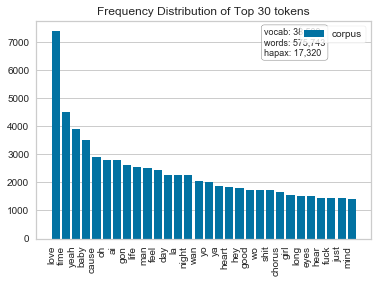

In [116]:
from sklearn.feature_extraction.text import CountVectorizer

from yellowbrick.text import FreqDistVisualizer

# Load the text data


vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(df_demo['nltk_lyrics'])
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v',n=30)
visualizer.fit(docs)
visualizer.show()

In [117]:
#Control Panel - Hyper Parameters

#Count Vectorizer
max_features = 500 #500
max_df = .08



#LDA
n_topics = 3  #10


#LDA Display
display_n_chunks = 2 #5
n_topics = 10        #20
n_words = 10       #5



In [118]:
#Count Vectorizer
vect = CountVectorizer(max_features=max_features, max_df=max_df,stop_words='english')
X = vect.fit_transform(df_demo['nltk_lyrics'])

## Topic Analysis

In [119]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=n_topics, learning_method="batch",
                                max_iter=15, random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

print("lda.components_.shape: {}".format(lda.components_.shape))

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(n_topics), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words)





/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


lda.components_.shape: (10, 500)
topic 0       topic 1       
--------      --------      
ooh           la            
boy           en            
bad           te            
music         mi            
big           tu            
people        el            
got           se            
doo           es            
walk          lo            
money         si            


topic 2       topic 3       
--------      --------      
change        ya            
goodbye       niggas        
road          nigga         
lord          verse         
days          fuck          
lonely        wit           
help          ass           
times         money         
heaven        body          
care          ride          


topic 4       topic 5       
--------      --------      
sun           da            
blue          die           
stay          break         
feeling       und           
tonight       fly           
morning       summer        
going         playin        
ready 

In [120]:
def playlist_element(topics=range(n_topics), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words):
    playlists = []
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        #print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        #print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                #print(("{:<14}" * len_this_chunk).format(
                #    *feature_names[sorting[these_topics, i]]))
                playlists.append(feature_names[sorting[these_topics, i]][0])
            except:
                pass
        print("\n")
    return playlists

In [121]:
playlists = playlist_element()

In [122]:
playlists[0]

'ooh'

In [123]:
def create_ssp(n_words,playlists):
    playlist = []
    for x in range(n_words):
        playlist.append(playlists[x])
    return playlist
        
        
    

In [124]:
playlist = create_ssp(n_words,playlists)

In [125]:
playlist

['ooh', 'boy', 'bad', 'music', 'big', 'people', 'got', 'doo', 'walk', 'money']

## Rough Create SSP

In [126]:
def find_lyrics(lyrics,element,playlist_position):
    if(lyrics.find(element)!= -1):
        return playlist_position
    else:
        return None


In [127]:
def make_ssp(playlist):
    df_demo_ssp = df_demo
    ssp = []
    for slot in range(len(playlist)):
#reset to org state
        df_demo_ssp['playlist_index_{s}'.format(s=slot)] = df_demo_ssp.apply(lambda x: find_lyrics(x['lyrics']
                                                                            ,playlist[slot],slot),axis=1)
        x = df_demo_ssp.dropna()
        y = x[(x['valence'] == x['valence'].max())]
        z = y[(y['energy'] == y['energy'].max())]

        print(z.track_uri.values[0])
        ssp.append({'artist_name':z.artist_name.values[0],'track_name':z.track_name.values[0],'track_uri':z.track_uri.values[0],
                   'valence':y.valence.values[0],'energy':z.energy.values[0],'lyrics':z.lyrics.values[0]})

        df_demo_ssp = df_playlist.drop(index=z.index)
    return ssp

In [128]:
ssp = make_ssp(playlist)
#playlist[0]

4MEyWIXKBFWaXpRIdJv354
7s9si69INQWnNd3RLz3Elo
45Yhz3bJ45YGA0Qfgn06ix
5jjt6Qa4PbsgpEMgz5WzL1
1JhFQ8L6QZxQchBa5qJrxS
5jjt6Qa4PbsgpEMgz5WzL1
1S6rSlrHMUQEgyI43PnOkF
24qcDZtqYSUOr83QXgy8aa
1eLag4BSaKr983nzatl2bw
77eyCWTuqvAM2EGqw72Lxf


In [129]:
df_ssp = pd.DataFrame(ssp)
df_ssp

,artist_name,energy,lyrics,track_name,track_uri,valence
0,Gary's Gang,0.683,OohÃ ah OohÃ ah OohÃ ah OohÃ ah OohÃ ah K...,keep on dancin',4MEyWIXKBFWaXpRIdJv354,0.969
1,Exposé,0.796,"I tell myself, ""Don't call him up"" But I long ...",still hung up on you,7s9si69INQWnNd3RLz3Elo,0.982
2,Eddy Grant,0.704,Well Jo'anna she runs a country She runs in Du...,hope joanna,45Yhz3bJ45YGA0Qfgn06ix,0.980
3,A*Teens,0.976,"Floorfiller, floorfiller, floorfiller Hey Mr. ...",floorfiller - radio edit,5jjt6Qa4PbsgpEMgz5WzL1,0.990
4,Barney,0.660,Barney is a dinosaur from our imagination And ...,barney theme song,1JhFQ8L6QZxQchBa5qJrxS,0.996
5,A*Teens,0.976,"Floorfiller, floorfiller, floorfiller Hey Mr. ...",floorfiller - radio edit,5jjt6Qa4PbsgpEMgz5WzL1,0.990
6,The Dandy Warhols,0.348,Of mine or could be Hell Or maybe I'm not eheh...,welcome to the monkey house,1S6rSlrHMUQEgyI43PnOkF,0.992
7,Eddie Hodges,0.857,"I'm gonna knock on your door, ring on your bel...",i'm gonna knock on your door,24qcDZtqYSUOr83QXgy8aa,0.993
8,Anything Box,0.627,"(claude s.) (peace, love, worth, hope) Everyth...",hope,1eLag4BSaKr983nzatl2bw,0.983
9,Bill Wyman,0.724,It's a hard life People get affected By the to...,affected by the towns,77eyCWTuqvAM2EGqw72Lxf,0.988


## Visualization (Valence Curve, Energy Curve)

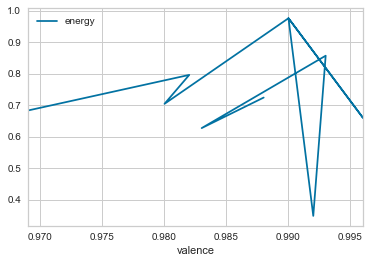

In [130]:
df_ssp.plot.line(x='valence',y='energy')

## Create Spotify Playlist

In [131]:
import requests
import json
import pandas as pd
import spotipy#authentication
import spotipy.util as util#authentication
from spotipy.oauth2 import SpotifyClientCredentials#authentication

In [132]:
cid = '049ade7215e54c63a2b628f3784dc407'
secret = '5d30770120ad4dbbabbb5ce538110e05'
redirect_uri = 'http://google.com/'
username = 'name'

In [133]:
#Authentication

scope = 'playlist-modify-private'
token_playlist = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_playlist:
    sp_playlist = spotipy.Spotify(auth=token_playlist)
else:
    print("Can't get token for", username)
    
#Authentication

scope = 'user-read-private'
token_user = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_user:
    sp_user = spotipy.Spotify(auth=token_user)
else:
    print("Can't get token for", username)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=049ade7215e54c63a2b628f3784dc407&response_type=code&redirect_uri=http%3A%2F%2Fgoogle.com%2F&scope=playlist-modify-private in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQAp89SsleOpf_Hbp4x-HEfnkAjfmVcLoZqlt_KrxXpDVYN-mPyakYf1WOeNp2ZBvdQzgM-2u4aB2KTssyveZM9G6GMHArM9a1c7kV8SzMljf3K2-4Fpd16AeHvW4djBUzDBvuDw4dddQ4ywW6dhPQf3zANkJ2wPcs10YnIbldKQy1FypwEhtql7Rmzl1ZoQJJbo5-6xRlv_i264rHo4PGU




            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you wer

In [134]:
def get_user_id(url):
    try:
        resp = requests.get(url,headers={'Authorization': 'Bearer ' + token_user},
                             #data={"name": "SSP"}
                           )
        
        resp.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        
    
    response = resp.json()
    userid = response['id']
    
    return userid


In [135]:
user_id = get_user_id('https://api.spotify.com/v1/me')

In [136]:
identification = user_id
identification

'124399179'

In [140]:
playlist = sp_playlist.user_playlist_create(identification,'SSP', public=False, description="First SSP")

In [141]:
playlist

{'collaborative': False,
 'description': 'First SSP',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/3hGrlzi3ZDFseBWzQ2Luxm'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/3hGrlzi3ZDFseBWzQ2Luxm',
 'id': '3hGrlzi3ZDFseBWzQ2Luxm',
 'images': [],
 'name': 'SSP',
 'owner': {'display_name': 'Adam Goldstein',
  'external_urls': {'spotify': 'https://open.spotify.com/user/124399179'},
  'href': 'https://api.spotify.com/v1/users/124399179',
  'id': '124399179',
  'type': 'user',
  'uri': 'spotify:user:124399179'},
 'primary_color': None,
 'public': False,
 'snapshot_id': 'MSw5Nzc1NWQyZWMyOGIyNTliNGIzY2ZhYmJmOWIyOWI4ZmMwNTM4NTI2',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/3hGrlzi3ZDFseBWzQ2Luxm/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:playlist:3hGrlzi3ZDFseBWzQ2Luxm'}

In [142]:
playlist_tracks = sp_playlist.user_playlist_add_tracks(identification,playlist['id'],df_ssp['track_uri'], position=None)

## unigrams

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {i}:".format(i=topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#How many words per topic
no_top_words = 4
display_topics(nmf, tfidf_feature_names, no_top_words)